<a href="https://colab.research.google.com/github/GyuhoonK/NLP-Friends/blob/master/Friends_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Drive Mount

In [ ]:
from google.colab import auth
from google.colab import drive
auth.authenticate_user()
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#2. Prepare For BERT <br>
tensorflow, trnasformers를 사용합니다.<br>
transformers는 기본 라이브러리가 아니므로 설치를 진행합니다.

In [ ]:
!pip install transformers --quiet
!pip install bert-tensorflow --quiet

     |████████████████████████████████| 675kB 3.4MB/s 
     |████████████████████████████████| 890kB 14.9MB/s 
     |████████████████████████████████| 3.8MB 21.6MB/s 
     |████████████████████████████████| 1.1MB 42.0MB/s 
     |████████████████████████████████| 71kB 2.3MB/s 


In [ ]:
#library importing
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import pickle
import json
import datetime

from transformers import BertTokenizer
from transformers import TFBertModel

In [ ]:
#Friends dataset이 지정된 기본 경로를 설정합니다
friends_path = '/content/gdrive/My Drive/Colab Notebooks/NLP/Friends/'

#3. Pipeline <br>
emotion label을 num value로 치환하고 전처리를 시작합니다.<br>
2개 문장을 하나의 input으로 만듭니다. <br>
input_sentence = [1st sentence(현재 발화)] + [2nd sentence(이전 발화)]<br>
label = [emotion of 1st sentence]<br>
각 dialogue의 첫번째 문장은 이전 발화가 존재하지 않으므로 하나의 문장으로만 input_sentence를 구성합니다.<br>



In [ ]:
# make emotion classes #
with open(friends_path + 'friends_train.json', 'rb') as f :
  data = json.load(f)
f.close()

result = pd.DataFrame()
for i , dia in enumerate(data):
  tmp = pd.DataFrame.from_dict(dia)
  tmp['dialogue'] = i
  result = pd.concat([result, tmp])
emot2num = {emot : i for i, emot in enumerate(result['emotion'].drop_duplicates().values)}
emot2num

make_pair 함수를 이용해 2개 문장을 하나의 input으로 만듭니다.<br>
input = [(N)th speaker, (N)th utterance] +  [(N-1) speaker, (N-1)th utterance]<br>
각 dialogue의 첫번째 utterance는 이전 utterance가 없으므로 하나의 utterance로만 구성됩니다.

In [ ]:
def make_pair(file_path, emot2num):

  with open(file_path, 'rb') as f:
    data = json.load(f)
    df = pd.DataFrame()
    for i, dia in enumerate(data):
      tmp = pd.DataFrame.from_dict(dia)
      tmp['dialogue'] = i
      df = pd.concat([df, tmp])
  f.close()
  df['emotion'].replace(emot2num, inplace=True)
  for col in ['speaker','utterance','emotion'] :
    df[col] = df[col].astype(str)
  
  input_pair = []
  input_label = []
  for i in df.dialogue.drop_duplicates().values:
    tmp = df[df.dialogue == i]
    tmp.reset_index(inplace=True, drop=True)
    
    for row in tmp.index :
      
      if row == 0:
        input_pair.append([[tmp.loc[row, 'speaker'], tmp.loc[row, 'utterance']]])
        
      else :
        now_ = [tmp.loc[row, 'speaker'], tmp.loc[row, 'utterance']]
        ex_ = [tmp.loc[row-1, 'speaker'],tmp.loc[row, 'utterance']]
        input_pair.append([now_, ex_])
        
      input_label.append(tmp.loc[row, 'emotion'])
  input_label = tf.one_hot(np.array(input_label),  depth = len(emot2num))
  return input_pair, input_label

In [ ]:
train_input,train_label = make_pair(friends_path + 'friends_train.json', emot2num)

tokenizer를 이용해 token으로 만듭니다

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',)

check_len = []
for inputs in train_input:
  second_len = 0
  for i, stc in enumerate(inputs):
    sentence = ' '.join(stc)
    if i == 1:
      second_len = len(tokenizer.encode(sentence))
    if i == 0:
      first_len = len(tokenizer.encode(sentence))
  check_len.append(second_len + first_len)

이후 수행 결과 input_sentece들의 문장 길이를 확인해보았습니다.<br>
최대 길이가 192였고, 이들을 모두 포함할 수 있도록 maximum_length를 256으로 설정합니다.<br>
이후, 입력 문장은 tokenizer를 통해 num_vector로 반환하고, segment, mask token을 추가합니다.

max length of input : 192


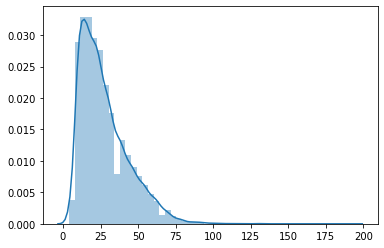

In [ ]:
import seaborn as sns
check_len = np.array(check_len)
sns.distplot(check_len)
print("max length of input : {}".format(np.max(check_len)))

In [ ]:
MAX_SEQ = 256

In [ ]:
def make_inputs(max_seq, inputs, tokenizer):
  input_ids = []
  input_masks = []
  second_len = 0
  for i, stc in enumerate(inputs):
    sentence = ' '.join(stc)
    if i == 0:
      input_ids+= tokenizer.encode(sentence)
      first_len = len(tokenizer.encode(stc))

    if i == 1:
      input_ids += tokenizer.encode(sentence)[1:]
      second_len = len(tokenizer.encode(stc)[1:])
    
  while True :
    if len(input_ids) <= max_seq:
      break
    input_ids.pop()

  input_ids[-1] = 102
  input_segments = [0] * first_len
  input_segments += [1] * (len(input_ids) - first_len)

  input_masks = [1] * len(input_ids)
  padding = [0] * (max_seq - len(input_ids))
  input_ids += padding
  input_segments += padding
  input_masks += padding

  return input_ids, input_masks, input_segments

In [ ]:
def make_inputdataset(file_path, emot2num, max_seq):
  pair, labels = make_pair(file_path, emot2num)
  
  ids = []
  masks = []
  segments = []
  for i in pair:
    ids_, mask_, seg_ = make_inputs(MAX_SEQ, i, tokenizer)
    ids.append(ids_)
    masks.append(mask_)
    segments.append(seg_)

  return np.array(ids), np.array(masks), np.array(segments), np.array(labels)

위에서 정의한 함수들을 이용해 BERT모델을 위한 input과 label을 만듭니다

In [ ]:
train_id, train_mask, train_seg, train_laebl = make_inputdataset(friends_path + 'friends_train.json', emot2num, MAX_SEQ)
test_id, test_mask, test_seg, test_label = make_inputdataset(friends_path + 'friends_test.json', emot2num, MAX_SEQ)
dev_id, dev_mask, dev_seg, dev_label = make_inputdataset(friends_path + 'friends_dev.json', emot2num, MAX_SEQ)

#4. Model Architecture<br>
BERT 모델에 Fully Connected Layer를 쌓아서 감정 분류를 할 수 있도록 모델을 구성합니다.<br>

In [ ]:
class FD(tf.keras.Model):
  def __init__(self, DROP_OUT, LAMD, CLASS_NUM):
    super(FD, self).__init__()
    self.bert = TFBertModel.from_pretrained('bert-base-uncased')
    self.dropout = tf.keras.layers.Dropout(DROP_OUT)
    self.dense1 = tf.keras.layers.Dense(CLASS_NUM, activation='softmax',
                                        kernel_regularizer = tf.keras.regularizers.l2(LAMD))
    
    
  def call(self, inputs, training = False):
    ids, mask, seg = inputs
    outputs = self.bert(ids, attention_mask = mask, token_type_ids = seg, training = training)
    seq_output, pooled_output = outputs
    x = self.dropout(pooled_output, training = training)
    x = self.dense1(x, training = training)

    return x

hyperparameter 값을 설정합니다.

In [ ]:
DROP_OUT = 0.1
LAMD = 1e-4
CLASS_NUM = 8

LEARNING_RATE = 2e-5
BATCH_SIZE = 8

train/dev을 나누기 위해 일단 모든 데이터셋을 합칩니다

In [ ]:
all_id = np.concatenate([train_id, test_id, dev_id])
all_seg = np.concatenate([train_seg, test_seg, dev_seg])
all_mask = np.concatenate([train_mask, test_mask, dev_mask])
all_label = np.concatenate([tf.argmax(train_label, axis = -1).numpy().reshape(-1, 1),
                            tf.argmax(test_label, axis = -1).numpy().reshape(-1, 1),
                            tf.argmax(dev_label, axis = -1).numpy().reshape(-1, 1)])

training data와 valid data를 만듭니다.(90% : 10%)<br>
label의 비율이 유지되도록 분류하였습니다(stratify).

In [ ]:
from sklearn.model_selection import train_test_split 

X_train = []
X_val = []

for X in [all_id, all_mask, all_seg]:
  x_train, x_val, y_train, y_val = train_test_split(X, all_label, test_size = 0.10 , # 10%(20k) used val set
                                                     random_state = 72, 
                                                    shuffle = True, # Shuffle all the dataset
                                                    stratify = all_label) # Keep the ratio
  X_train.append(x_train)
  X_val.append(x_val)

In [ ]:
y_train = tf.one_hot(y_train, depth= 8).numpy().reshape(-1, 8)
y_val = tf.one_hot(y_val, depth = 8).numpy().reshape(-1, 8)

#5. Training <br>
TPU를 이용하여 모델을 학습합니다.<br>


먼저 TPU를 할당받습니다

In [ ]:
### TPU setting ###

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

<b>Skewed Class Issues</b><br>
emotion label은 8개이지만 8개 label이 골고루 분포되어있지 않습니다.<br>
label의 대부분이 neutral, non-neutral입니다.<br>
이에 대처하기 위해 loss함수로 WeightedCategoricalCrossentopy를 정의하여 사용합니다.

In [ ]:
#label 비율 계산, loss 함수에 사용될 weight#
index, counts = np.unique(all_label, return_counts=True)
counts_ = np.min(counts) / counts
class_weights = {i : j for i, j in zip(index, counts_)}
pos_weights = np.array([weight for weight in class_weights.values()])

In [ ]:
with strategy.scope():
  model = FD(DROP_OUT, LAMD, CLASS_NUM)
  a = tf.constant(train_id[0])[None, :]
  b = tf.constant(train_mask[0])[None, :]
  c = tf.constant(train_seg[0])[None, :]
  result = model([a,b,c])
  print("check model output's shape : {}".format(result.shape))
  model.summary()
  optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

  class  WeightedCategoricalCrossentropy(tf.keras.losses.CategoricalCrossentropy):
    def __init__(self, cost_mat, name = 'weighted_categorical_crossentropy', **kwargs):
      cost_mat = np.array(cost_mat)
      super().__init__(name = name, **kwargs)
      self.cost_mat = tf.keras.backend.cast_to_floatx(cost_mat)

    def __call__(self, y_true, y_pred, sample_weight = None):
      return super().__call__(y_true = y_true, y_pred = y_pred,
                              sample_weight = get_sample_weights(y_true, y_pred, self.cost_mat), )
    def get_config(self):
      config = super().get_config().copy()
      config.update({'cost_mat' : (self.cost_mat)})                          
      return config

    @classmethod 
    def from_config(cls, config):
      return cls(**config)
    
    
  def get_sample_weights(y_true, y_pred, cost_m):
    num_classes = len(cost_m)
    y_pred = tf.keras.backend.one_hot(tf.keras.backend.argmax(y_pred), num_classes)
    y_true_nk1 = tf.keras.backend.expand_dims(y_true, 2)
    y_pred_n1k = tf.keras.backend.expand_dims(y_pred, 1)
    cost_m_1kk = tf.keras.backend.expand_dims(cost_m, 0)
    sample_weights_nkk = cost_m_1kk * y_true_nk1 * y_pred_n1k
    sample_weights_n = tf.keras.backend.sum(sample_weights_nkk, axis = [1, 2])
    return sample_weights_n

  tf.keras.losses.WeightedCategoricalCrossentropy = WeightedCategoricalCrossentropy

  model.compile(optimizer = optimizer,
               loss = WeightedCategoricalCrossentropy(pos_weights),
               metrics = ['acc'])

check model output's shape : (1, 8)
Model: "fd_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tf_bert_model_2 (TFBertModel multiple                  109482240 
_________________________________________________________________
dropout_113 (Dropout)        multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  6152      
Total params: 109,488,392
Trainable params: 109,488,392
Non-trainable params: 0
_________________________________________________________________


overfitting 지점 직전까지 학습된 weight를 이용하기 위해 callback을 선언합니다

In [ ]:
cb = tf.keras.callbacks.ModelCheckpoint(friends_path + 'weighted_best_loss_.h5', 
                                               save_best_only = True,
                                               save_weights_only = True)

In [ ]:
hist = model.fit(x = X_train, y = y_train,
                 batch_size = BATCH_SIZE,
                 epochs = 5,
                 validation_data = (X_val, y_val),
                 callbacks = [cb])
model.save_weights(friends_path + 'weighted_last_loss.h5')

Epoch 1/5
816/816 [==============================] - 90s 111ms/step - loss: 0.0980 - acc: 0.5586 - val_loss: 0.1070 - val_acc: 0.5810
Epoch 2/5
816/816 [==============================] - 80s 98ms/step - loss: 0.0979 - acc: 0.6348 - val_loss: 0.1343 - val_acc: 0.5789
Epoch 3/5
816/816 [==============================] - 79s 97ms/step - loss: 0.0889 - acc: 0.6892 - val_loss: 0.1342 - val_acc: 0.6099
Epoch 4/5
816/816 [==============================] - 78s 95ms/step - loss: 0.0756 - acc: 0.7452 - val_loss: 0.1447 - val_acc: 0.5989
Epoch 5/5
816/816 [==============================] - 79s 96ms/step - loss: 0.0633 - acc: 0.7919 - val_loss: 0.1688 - val_acc: 0.5624


#6. Test - Kaggle Data<br>
학습이 완료된 모델을 Kaggle dataset을 이용하여 테스트합니다.<br>

In [ ]:
kaggle_path = '/content/gdrive/My Drive/Colab Notebooks/NLP/cose461e/'
data = pd.read_csv(kaggle_path + 'en_data.csv', encoding = 'CP949', index_col='id')
sample = pd.read_csv(kaggle_path + 'en_sample.csv', encoding = 'CP949', index_col = 'Id')

label이 없는 kaggle data를 tokenize하기 위해 새로 함수를 정의합니다.

In [ ]:
def make_pair_test(df, emot2num):
  for col in ['speaker','utterance'] :
    df[col] = df[col].astype(str)
  
  input_pair = []
  
  for i in df.i_dialog.drop_duplicates().values:
    tmp = df[df.i_dialog == i]
    tmp.reset_index(inplace=True, drop=True)
    
    for row in tmp.index :
      
      if row == 0:
        input_pair.append([[tmp.loc[row, 'speaker'], tmp.loc[row, 'utterance']]])
        
      else :
        now_ = [tmp.loc[row, 'speaker'], tmp.loc[row, 'utterance']]
        ex_ = [tmp.loc[row-1, 'speaker'],tmp.loc[row, 'utterance']]
        input_pair.append([now_, ex_])
  return input_pair

def make_inputdataset_test(df, emot2num, max_seq):
  pair = make_pair_test(df, emot2num)
  
  ids = []
  masks = []
  segments = []
  for i in pair:
    ids_, mask_, seg_ = make_inputs(MAX_SEQ, i, tokenizer)
    ids.append(ids_)
    masks.append(mask_)
    segments.append(seg_)

  return np.array(ids), np.array(masks), np.array(segments)

kaggle_id, kaggle_mask, kaggle_seg = make_inputdataset_test(data, emot2num, MAX_SEQ)

val_loss가 가장 낮은 model weight를 불러와 prediction을 실행합니다

In [ ]:
model.load_weights(friends_path + 'weighted_best_loss_.h5')

In [ ]:
pred = model.predict([kaggle_id, kaggle_mask, kaggle_seg])
pred = np.argmax(pred, axis = 1).reshape(-1, 1)
sample['Expected'] = pred

In [ ]:
#submit form에 맞게 변형#
num2emot = {i : j for i, j in zip(emot2num.values(), emot2num.keys())}
sample['Expected'].replace(num2emot, inplace=True)
sample.rename(columns = {'Expected' : 'Predicted'}, inplace=True)
sample.to_csv(kaggle_path + "submit_cose461e_{}.csv".format(datetime.datetime.now().strftime('%Y%m%d%H%M%S')))